## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-08-03 19:18:33.539 | INFO     |  Running on cpu


In [3]:
task = "BlockDrawerBlueGrab"
path = data_root / task / "demos"

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))

2025-08-03 19:18:36.281 | INFO     |  Loading dataset(s): 
2025-08-03 19:18:36.282 | INFO     |    Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/BlockDrawerBlueGrab/demos/metadata.json
2025-08-03 19:18:36.283 | INFO     |    Extracted gt object labels [0, 1, 2, 3, 4, 5, 6]
2025-08-03 19:18:36.283 | INFO     |    Extracted tsdf object labels []
2025-08-03 19:18:36.283 | INFO     |    Done! Data contains 4 trajectories.
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, d

In [4]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'static',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([160, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([160]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([160, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([160, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([160, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([160, 3, 256, 256]), device=cpu, dt

In [6]:
tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=True,
    add_gripper_action=True,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=50,
    fix_first_component=False,
    fix_last_component=False,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,
    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    repeat_final_step=50,
    repeat_first_step=0,
    components_prop_to_len=True,
    min_n_components=3,
    velocity_threshold=0.0004,
    max_idx_distance=8,
    min_end_distance=30,
    min_len=8
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-08-03 19:18:44.001 | INFO     |  Fitting AutoTPGMM
2025-08-03 19:18:44.001 | INFO     |  Performing fitting actions: [INIT]
2025-08-03 19:18:44.002 | INFO     |  Segmenting trajectories


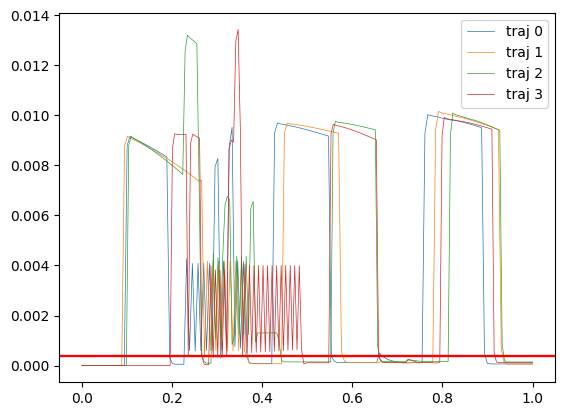

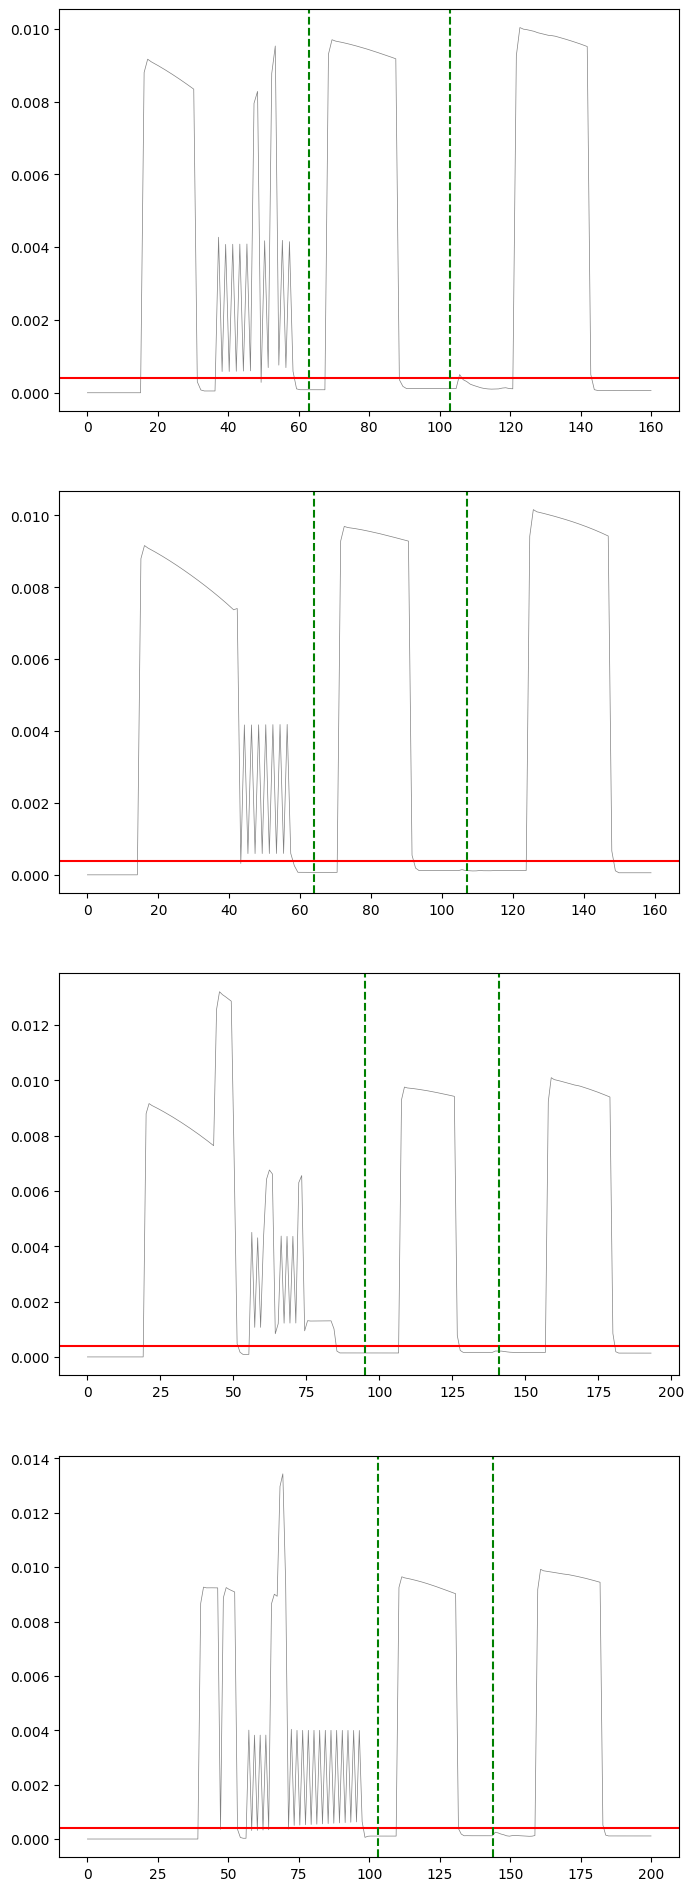

2025-08-03 19:18:45.034 | INFO     |  Creating segement of demos.
2025-08-03 19:18:45.042 | INFO     |  Subsampling to length 130 using strategy mean-length.
2025-08-03 19:18:45.043 | INFO     |  Creating segement of demos.
2025-08-03 19:18:45.051 | INFO     |  Subsampling to length 91 using strategy mean-length.
2025-08-03 19:18:45.053 | INFO     |  Creating segement of demos.
2025-08-03 19:18:45.059 | INFO     |  Subsampling to length 103 using strategy mean-length.
2025-08-03 19:18:45.060 | INFO     |  ... created 3 segments
2025-08-03 19:18:45.060 | INFO     |    Fitting candidate frame 1/10
2025-08-03 19:18:45.061 | INFO     |    Creating partial frame view of demos.
2025-08-03 19:18:45.066 | WARNING  |    Riemannian GMMs only make sense for rotations.
2025-08-03 19:18:45.066 | INFO     |    Manifold: TIME x R3 x R1
2025-08-03 19:18:45.066 | INFO     |    Changing number of components to 3
2025-08-03 19:18:45.067 | INFO     |    Model init ...


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:45.091 | INFO     |    Fitting candidate frame 2/10
2025-08-03 19:18:45.092 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:45.152 | INFO     |    Fitting candidate frame 3/10
2025-08-03 19:18:45.152 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:45.215 | INFO     |    Fitting candidate frame 4/10
2025-08-03 19:18:45.216 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:45.284 | INFO     |    Fitting candidate frame 5/10
2025-08-03 19:18:45.285 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:45.328 | INFO     |    Fitting candidate frame 6/10
2025-08-03 19:18:45.329 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:45.361 | INFO     |    Fitting candidate frame 7/10
2025-08-03 19:18:45.361 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:45.392 | INFO     |    Fitting candidate frame 8/10
2025-08-03 19:18:45.392 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:45.428 | INFO     |    Fitting candidate frame 9/10
2025-08-03 19:18:45.428 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:45.461 | INFO     |    Fitting candidate frame 10/10
2025-08-03 19:18:45.461 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:45.500 | INFO     |  ee_init    score (rel):     -0 (1.000)
2025-08-03 19:18:45.500 | INFO     |  obj000     score (rel):     -0 (1.000)
2025-08-03 19:18:45.501 | INFO     |  obj001     score (rel):     -0 (1.000)
2025-08-03 19:18:45.501 | INFO     |  obj002     score (rel):     -0 (1.000)
2025-08-03 19:18:45.501 | INFO     |  obj003     score (rel):     -0 (1.000)
2025-08-03 19:18:45.501 | INFO     |  obj004     score (rel):     -0 (1.000)
2025-08-03 19:18:45.501 | INFO     |  obj005     score (rel):     -0 (1.000)
2025-08-03 19:18:45.501 | INFO     |  obj006     score (rel):     -0 (0.002)
2025-08-03 19:18:45.501 | INFO     |  obj007     score (rel):     -0 (0.098)
2025-08-03 19:18:45.501 | INFO     |  obj008     score (rel):     -0 (0.007)
2025-08-03 19:18:45.502 | INFO     |  Creating partial frame view of demos.
2025-08-03 19:18:45.600 | INFO     |    Fitting candidate frame 1/10
2025-08-03 19:18:45.602 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:45.637 | INFO     |    Fitting candidate frame 2/10
2025-08-03 19:18:45.638 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:45.676 | INFO     |    Fitting candidate frame 3/10
2025-08-03 19:18:45.677 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:45.730 | INFO     |    Fitting candidate frame 4/10
2025-08-03 19:18:45.732 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:45.781 | INFO     |    Fitting candidate frame 5/10
2025-08-03 19:18:45.782 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:45.919 | INFO     |    Fitting candidate frame 6/10
2025-08-03 19:18:45.921 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:45.994 | INFO     |    Fitting candidate frame 7/10
2025-08-03 19:18:45.995 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:46.038 | INFO     |    Fitting candidate frame 8/10
2025-08-03 19:18:46.039 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:46.113 | INFO     |    Fitting candidate frame 9/10
2025-08-03 19:18:46.114 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:46.150 | INFO     |    Fitting candidate frame 10/10
2025-08-03 19:18:46.151 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:46.192 | INFO     |  ee_init    score (rel):     -0 (0.196)
2025-08-03 19:18:46.194 | INFO     |  obj000     score (rel):     -0 (0.196)
2025-08-03 19:18:46.194 | INFO     |  obj001     score (rel):     -0 (0.196)
2025-08-03 19:18:46.194 | INFO     |  obj002     score (rel):     -0 (0.196)
2025-08-03 19:18:46.194 | INFO     |  obj003     score (rel):     -0 (0.196)
2025-08-03 19:18:46.194 | INFO     |  obj004     score (rel):     -0 (0.196)
2025-08-03 19:18:46.194 | INFO     |  obj005     score (rel):     -0 (0.196)
2025-08-03 19:18:46.194 | INFO     |  obj006     score (rel):     -0 (0.004)
2025-08-03 19:18:46.195 | INFO     |  obj007     score (rel):     -1 (1.000)
2025-08-03 19:18:46.195 | INFO     |  obj008     score (rel):     -0 (0.004)
2025-08-03 19:18:46.195 | WARNING  |  Selected frames for segments 0 and 1 are disjoint. 
2025-08-03 19:18:46.200 | INFO     |  Adding frame 1 to segment 1.
2025-08-03 19:18:46.202 | INFO     |  Creating partial frame view of demo

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:46.306 | INFO     |    Fitting candidate frame 2/10
2025-08-03 19:18:46.307 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:46.358 | INFO     |    Fitting candidate frame 3/10
2025-08-03 19:18:46.359 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:46.618 | INFO     |    Fitting candidate frame 4/10
2025-08-03 19:18:46.618 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:46.675 | INFO     |    Fitting candidate frame 5/10
2025-08-03 19:18:46.676 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:46.724 | INFO     |    Fitting candidate frame 6/10
2025-08-03 19:18:46.724 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:46.779 | INFO     |    Fitting candidate frame 7/10
2025-08-03 19:18:46.780 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:46.835 | INFO     |    Fitting candidate frame 8/10
2025-08-03 19:18:46.836 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:46.870 | INFO     |    Fitting candidate frame 9/10
2025-08-03 19:18:46.870 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:46.913 | INFO     |    Fitting candidate frame 10/10
2025-08-03 19:18:46.913 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:46.946 | INFO     |  ee_init    score (rel):     -0 (0.485)
2025-08-03 19:18:46.948 | INFO     |  obj000     score (rel):     -0 (0.485)
2025-08-03 19:18:46.948 | INFO     |  obj001     score (rel):     -0 (0.485)
2025-08-03 19:18:46.949 | INFO     |  obj002     score (rel):     -0 (0.485)
2025-08-03 19:18:46.949 | INFO     |  obj003     score (rel):     -0 (0.485)
2025-08-03 19:18:46.949 | INFO     |  obj004     score (rel):     -0 (0.485)
2025-08-03 19:18:46.949 | INFO     |  obj005     score (rel):     -0 (0.485)
2025-08-03 19:18:46.949 | INFO     |  obj006     score (rel):     -0 (0.009)
2025-08-03 19:18:46.949 | INFO     |  obj007     score (rel):     -0 (1.000)
2025-08-03 19:18:46.949 | INFO     |  obj008     score (rel):     -0 (0.003)
2025-08-03 19:18:46.950 | INFO     |  Creating partial frame view of demos.
2025-08-03 19:18:46.953 | INFO     |  Segmented trajs into 3 segments
2025-08-03 19:18:46.996 | INFO     |  Frame score (abs):
            ee_init    obj0

Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:47.069 | INFO     |  Manifold: TIME x R3 x R3 x R3 x R3 x R3 x R3 x R3 x R1


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:47.173 | INFO     |  Manifold: TIME x R3 x R3 x R1


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

((array([[6.78e+26, 7.27e+26, 7.75e+26, ..., 2.30e+15, 1.40e+15, 8.45e+14],
         [2.77e+22, 3.45e+22, 4.28e+22, ..., 1.23e+23, 9.86e+22, 7.87e+22],
         [1.83e+17, 2.65e+17, 3.81e+17, ..., 7.20e+25, 6.71e+25, 6.23e+25]]),
  array([[2.57e+06, 2.60e+06, 2.62e+06, ..., 1.62e+03, 1.27e+03, 9.98e+02],
         [1.55e-24, 1.78e-24, 2.05e-24, ..., 9.41e+06, 8.19e+06, 7.10e+06],
         [7.13e-27, 9.00e-27, 1.13e-26, ..., 1.40e+08, 1.34e+08, 1.28e+08]]),
  array([[3.89e+04, 4.10e+04, 4.29e+04, ..., 5.26e-02, 4.09e-02, 3.17e-02],
         [3.36e+00, 4.01e+00, 4.76e+00, ..., 1.82e+02, 1.53e+02, 1.28e+02],
         [4.81e-04, 6.53e-04, 8.82e-04, ..., 7.89e+03, 7.46e+03, 7.03e+03]])),
 (-60.85393368810528, -18.36175868940313, -9.418212083585157))

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-08-03 19:18:47.658 | INFO     |  Did not specify time_based, deciding automatically.
2025-08-03 19:18:47.764 | WARNING  |  Skippig NaN Gaussians.


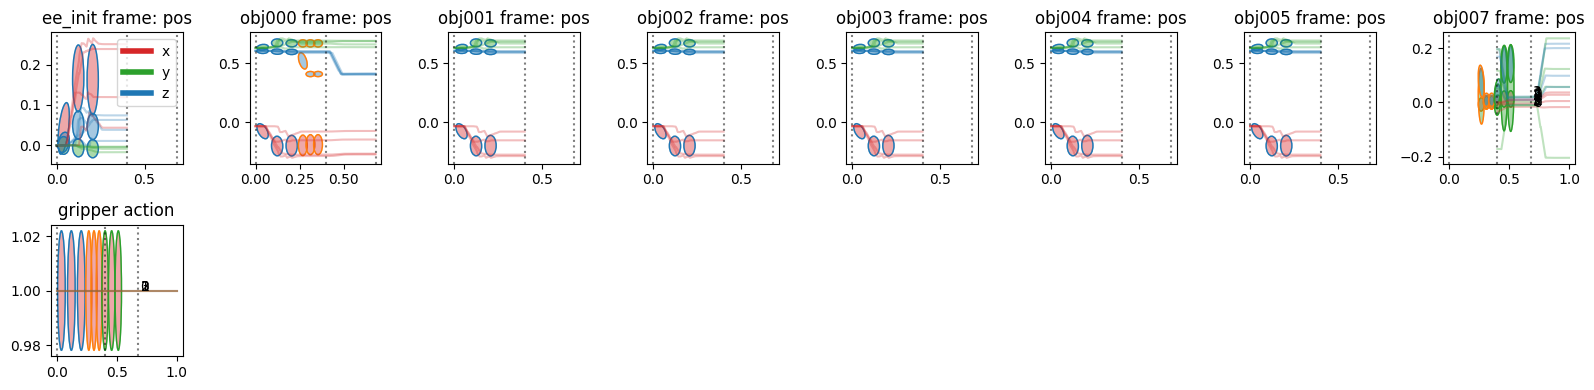

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-08-03 19:18:50.131 | INFO     |  Fitting AutoTPGMM
2025-08-03 19:18:50.132 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:18:50.142 | INFO     |  HMM EM ...
2025-08-03 19:18:50.145 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2025-08-03 19:18:50.168 | INFO     |  HMM init priors not defined, initializing to uniform
2025-08-03 19:18:50.328 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.00e+000, 1.00e+000, 1.00e+000, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [0.00e+000, 8.94e-232, 2.32e-224, ..., 1.03e-082, 8.31e-087,
          2.40e-089],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.00e+000, 1.00e+000,
          1.00e+000]]),
  array([[1.00e+00, 1.00e+00, 1.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.28e-57, 6.96e-61, 1.09e-62],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.00e+00, 1.00e+00, 1.00e+00]]),
  array([[1.00e+000, 1.00e+000, 1.00e+000, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [0.00e+000, 2.29e-175, 1.79e-167, ..., 1.00e+000, 1.00e+000,
          1.00e+000],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.00e-301, 4.23e-209,
          2.25e-116]])),
 (8839.126992302037, 1730.1100606278983, 1038.3191743437053))

2025-08-03 19:18:51.278 | INFO     |  Did not specify time_based, deciding automatically.


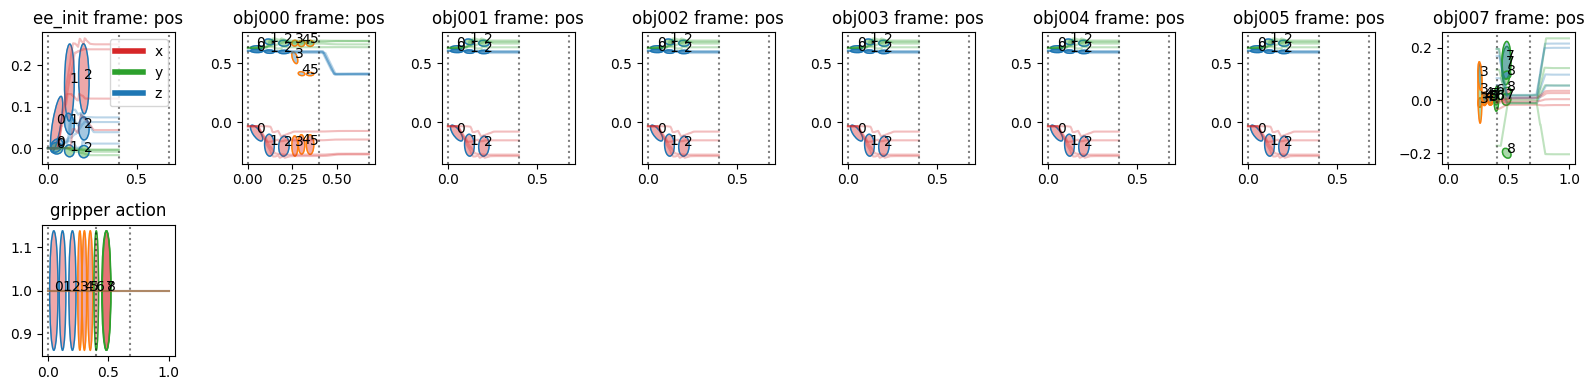

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

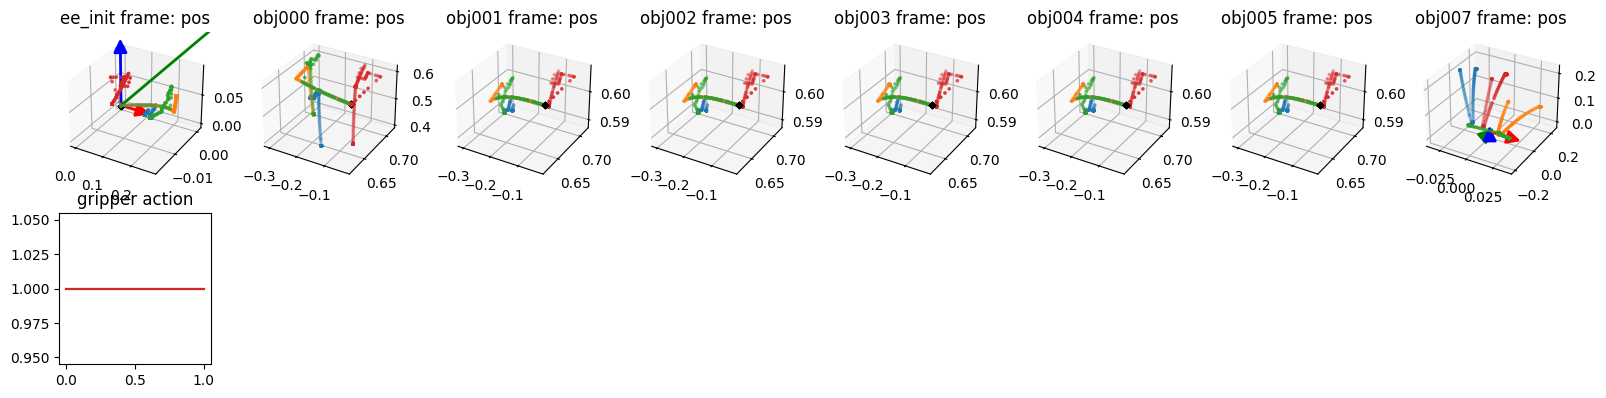

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

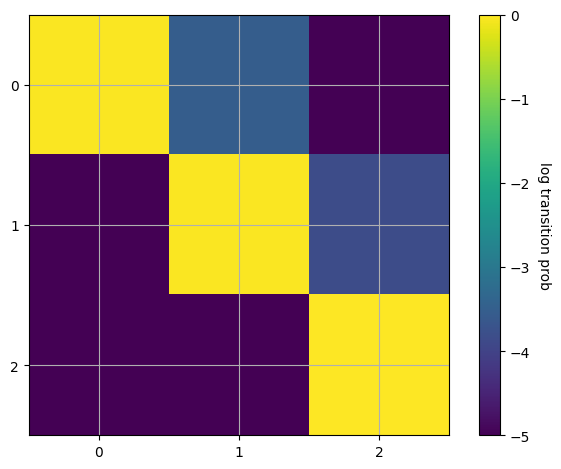

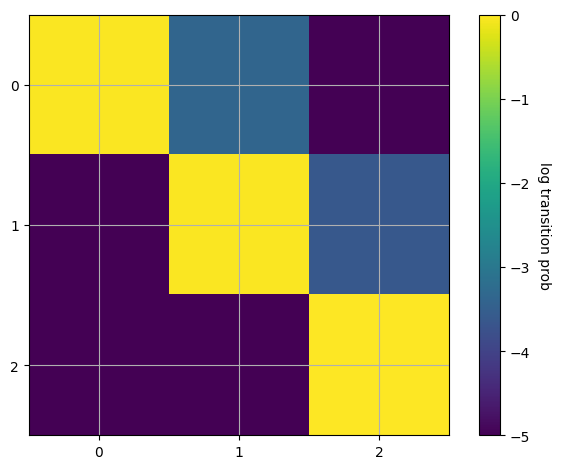

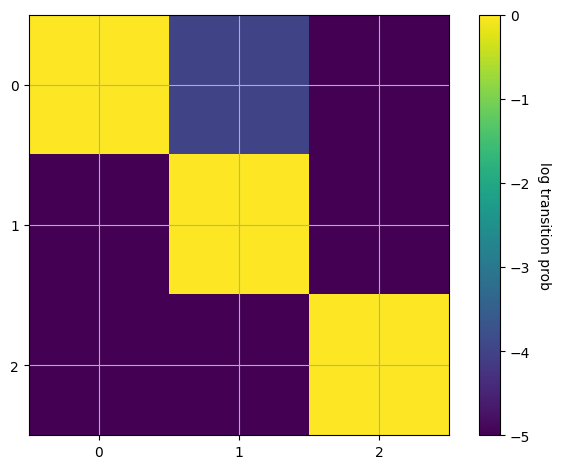

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2025-08-03 19:18:57.217 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-08-03 19:18:57.417 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-08-03 19:18:57.470 | INFO     |  Caculated segment transition probabilities: (array([[0.29]]), array([[0.42]]))
2025-08-03 19:18:57.471 | INFO     |  Creating partial frame view of demos.
2025-08-03 19:18:57.529 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:18:57.635 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:18:57.740 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:18:57.869 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/4 [00:00<?, ?it/s]

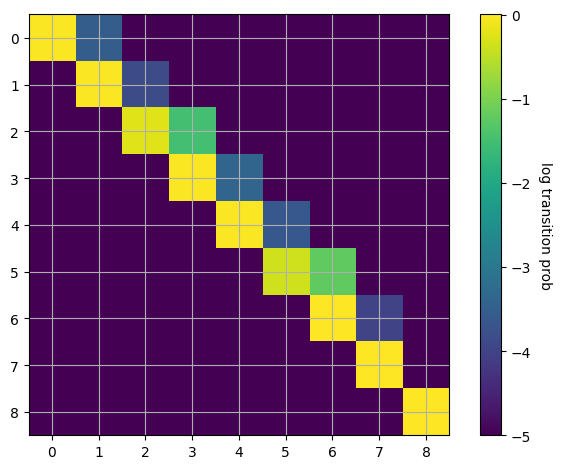

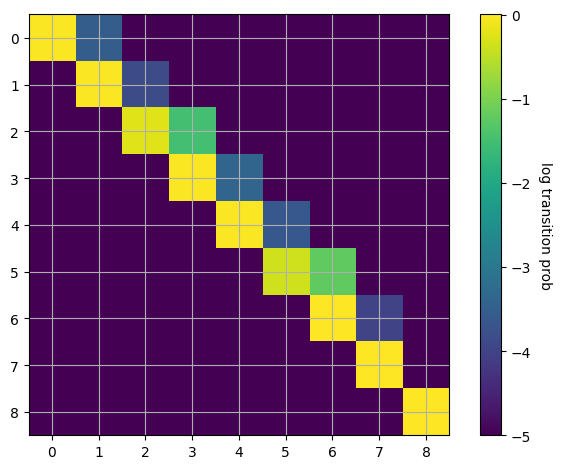

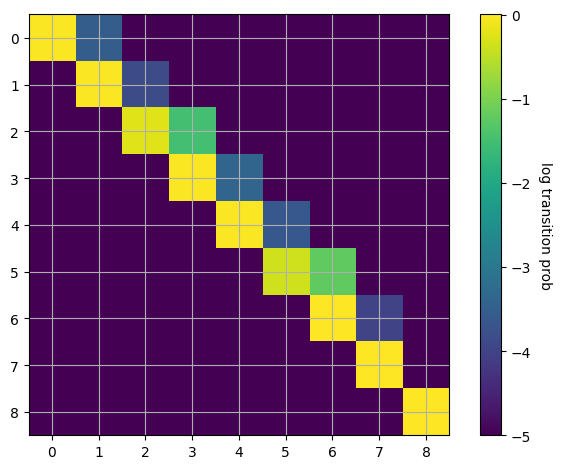

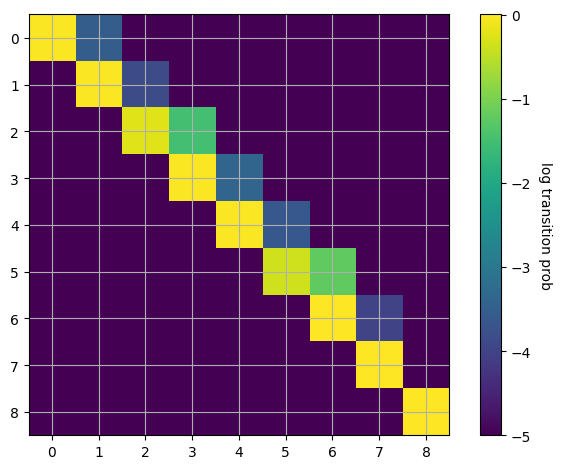

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-08-03 19:19:01.084 | INFO     |  Taking frame origins from demos.


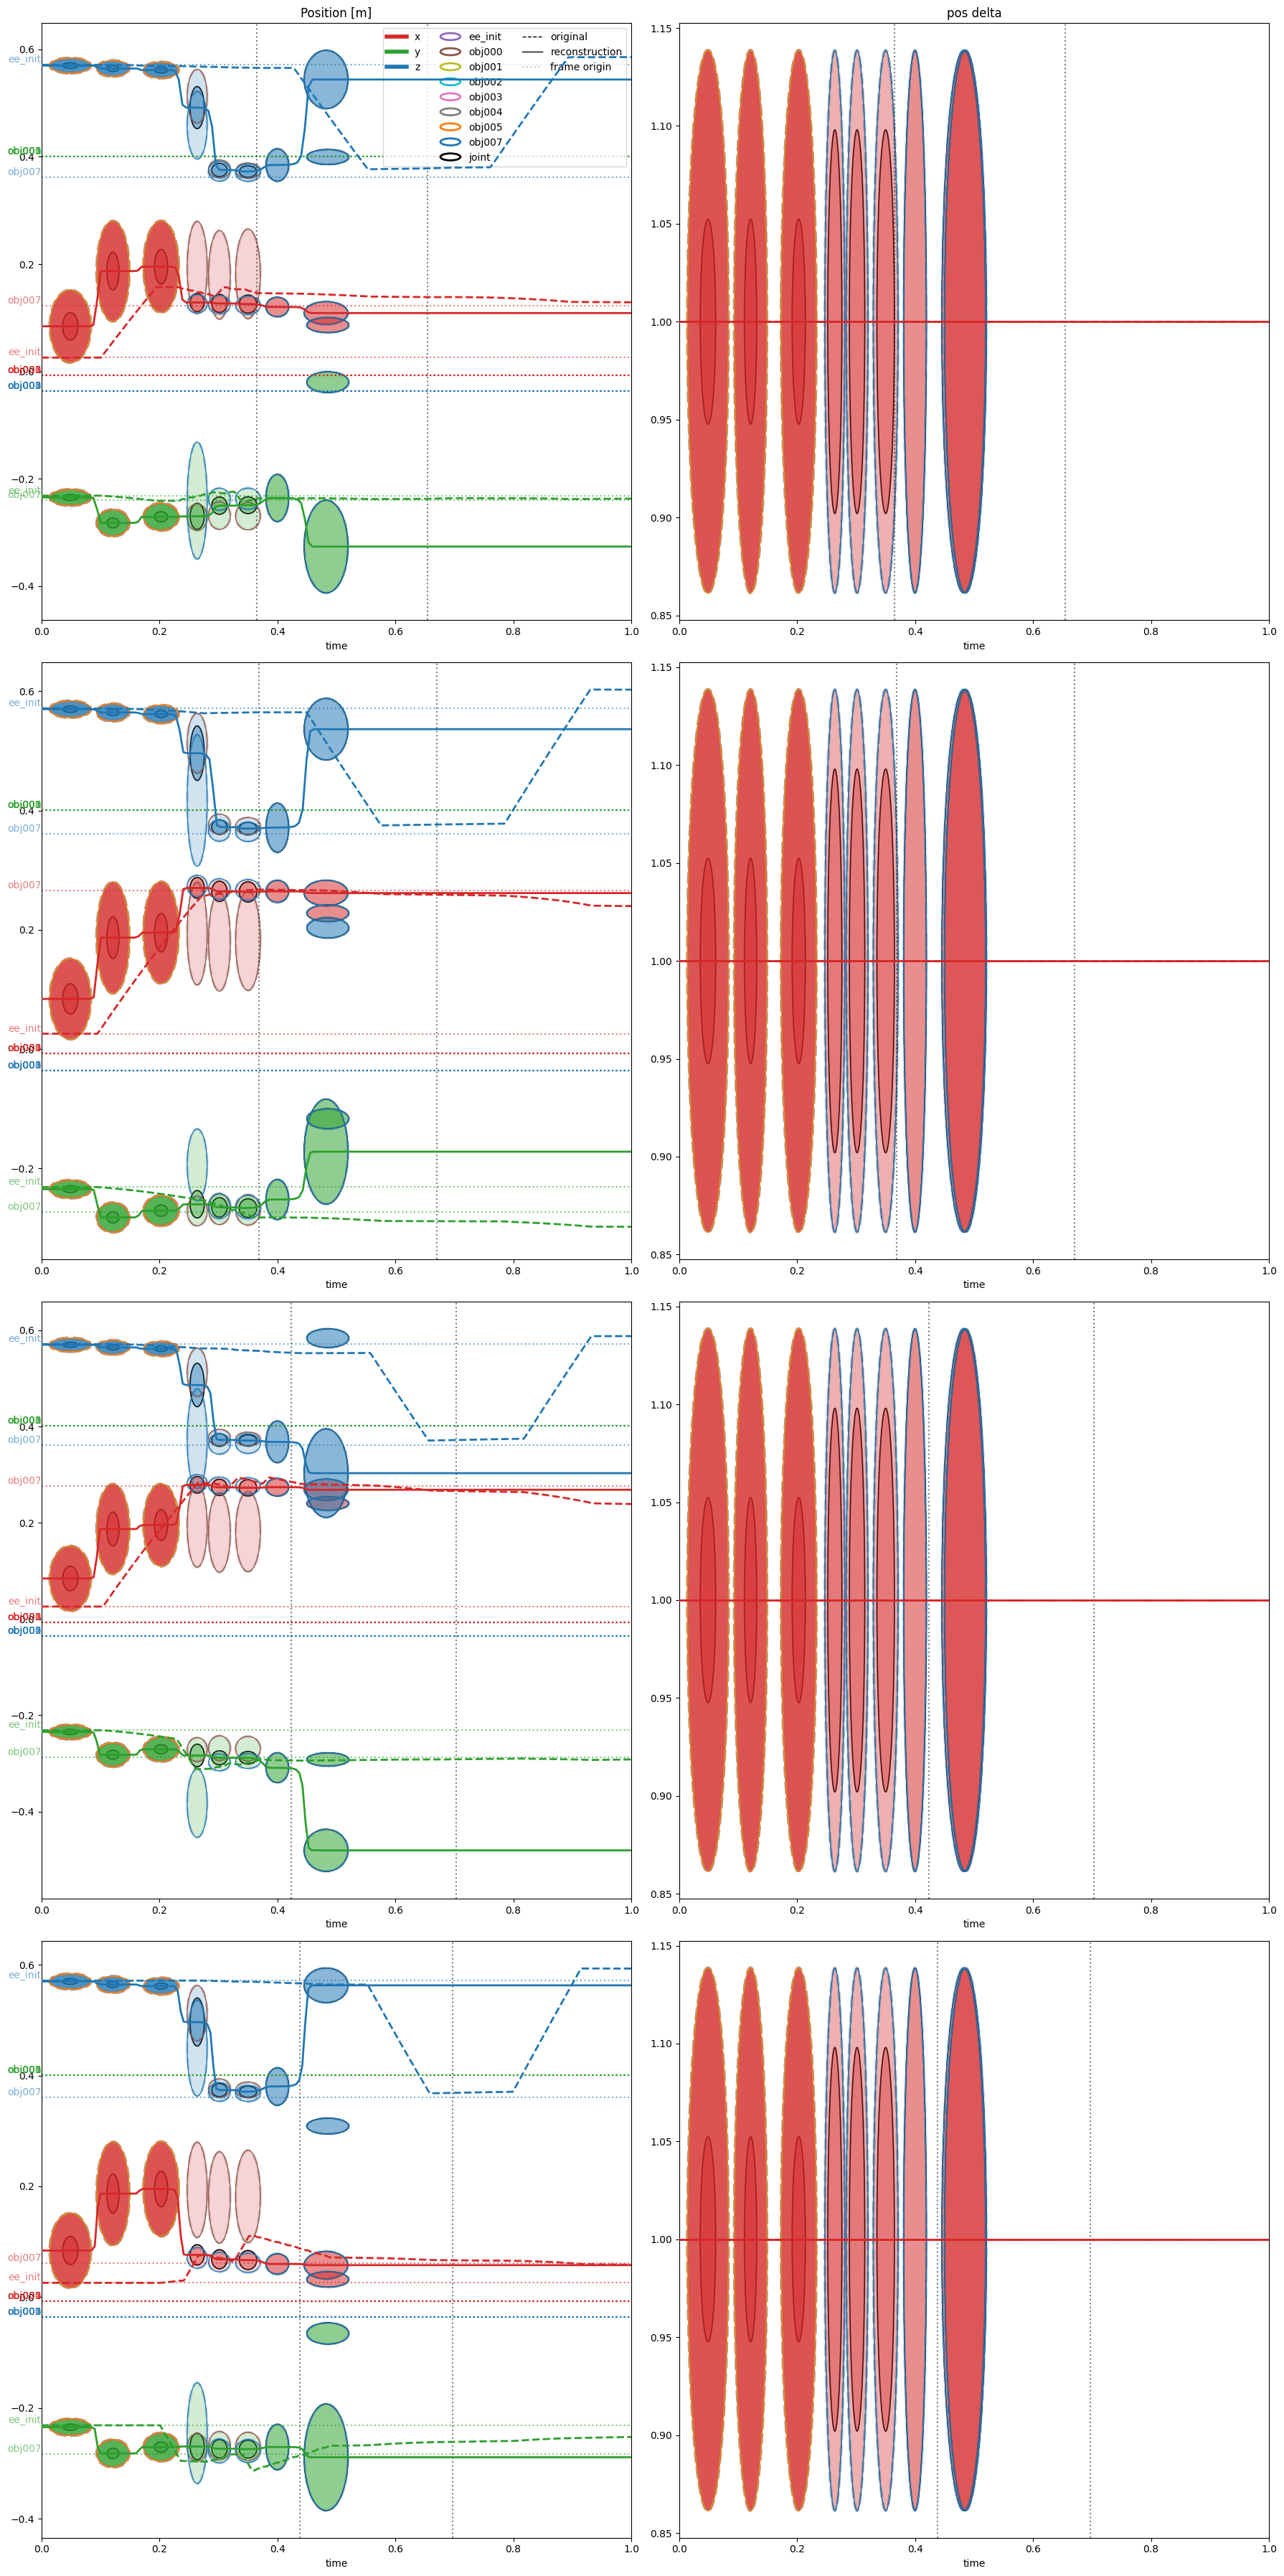

In [17]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


In [18]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)


IndexError: tuple index out of range